In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/agastya/miniforge3/lib/python3.10/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
from fastai.vision.all import *

In [3]:
destination_folder = Path.cwd()/'Dataset'/'collected'

Understanding little about dataset
## Dataset Credits/Citations:
### Japanese
- Kuzushiji Kanji Dataset (https://datasets.activeloop.ai/docs/ml/datasets/kuzushiji-kanji-kkanji-dataset/)
MNIST Replacement, 28x28 grayscale, 70k images
- Kuzushiji-Kanji (https://github.com/rois-codh/kmnist)\
Kuzushiji a term for the distorted shape of handwritten kanji\
Kanji are the logographic Chinese characters adapted from the Chinese script used in the writing of Japanese.\
This is what would make this project interesting as it would be difficult for classifier for classification similar looking characters into two classification
### Chinese
(https://github.com/lizhaoliu-Lec/CCSE)
The bellow dataset were created to identify the strokes but we won't be using much of that data; our concern would be limited to access images.
- Handwritten Chinese Character Stroke Extraction Dataset (6131 train images; variable sized)
- Kaiti Chinese Character Stroke Extraction Dataset; Computer font (6131 train images; \
*Dataset Structure for both*
- annotation
- train2021
- val2021
- test2021

In [4]:
%%capture
!pip install deeplake

In [5]:
import deeplake
ds = deeplake.load('hub://activeloop/kuzushiji-kanji')

/home/agastya/miniforge3/lib/python3.10/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.18) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/kuzushiji-kanji



\

hub://activeloop/kuzushiji-kanji loaded successfully.



In [6]:
ds.summary()

Dataset(path='hub://activeloop/kuzushiji-kanji', read_only=True, tensors=['images', 'labels'])

 tensor      htype          shape         dtype  compression
 -------    -------        -------       -------  ------- 
 images      image     (140424, 64, 64)   uint8    jpeg   
 labels   class_label    (140424, 1)     uint32    None   


In [7]:
totalimgs = len(ds.images)
divider = totalimgs // 12000
divider

11

In [8]:
image = ds.images[0].numpy()
image.shape, image[20:24, 20:24]

((64, 64),
 array([[  0,   1, 174, 255],
        [  0,  29, 198, 255],
        [ 41, 130, 236, 251],
        [126, 229, 250, 255]], dtype=uint8))

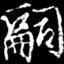

In [9]:
img = Image.fromarray(image)
img

In [10]:
diff = np.full(image.shape, 255, dtype=np.uint8) - image

In [11]:
img = Image.fromarray(diff)

In [12]:
img.save(Path.cwd()/'test.png')

### Saving random images in the japanese

In [ ]:
os.makedirs(destination_folder/'japanese', exist_ok=True)
for i in range(0, totalimgs, divider):
    image = ds.images[i].numpy()
    img = np.full(image.shape, 255, dtype=np.uint8) - image
    img = Image.fromarray(img)
    img.save(destination_folder/'japanese'/f'{i}.png' )

In [ ]:
# Saving validation img set
os.makedirs(Path.cwd()/'Dataset'/'test', exist_ok=True)
for i in range(2,8):
    image = ds.images[i].numpy()
    img = np.full(image.shape, 255, dtype=np.uint8) - image
    img = Image.fromarray(img)
    img.save(Path.cwd()/'Dataset'/'test'/f'japanese{i}.png') 

## Formatting Chineese Dataset

In [13]:
os.makedirs(destination_folder/'chinese', exist_ok=True)

In [14]:
handwrittenChineseTrainPath = Path('.').cwd()/'Dataset'/'handwritten_chinese_stroke_2021'/'train2021'
printedChineseTrainPath = Path('.').cwd()/'Dataset'/'kaiti_chinese_stroke_2021'/'train2021'

In [ ]:
handwrittenChineseTrain = [shutil.copy(handwrittenChineseTrainPath/file, destination_folder/'chinese') for file in os.listdir(handwrittenChineseTrainPath) if 'Zone.Identifier' not in file]
printedChineseTrain = [shutil.copy(printedChineseTrainPath/file, destination_folder/'chinese') for file in os.listdir(printedChineseTrainPath) if 'Zone.Identifier' not in file]
# len(handwrittenChineseTrain), len(printedChineseTrain)

In [15]:
chineseTrain = destination_folder/'chinese'
japaneseTrain = destination_folder/'japanese'

In [16]:
# Creating a datablock
language = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.025),
    get_y = parent_label,
    item_tfms =Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'), batch_tfms = aug_transforms(mult = 1.5))

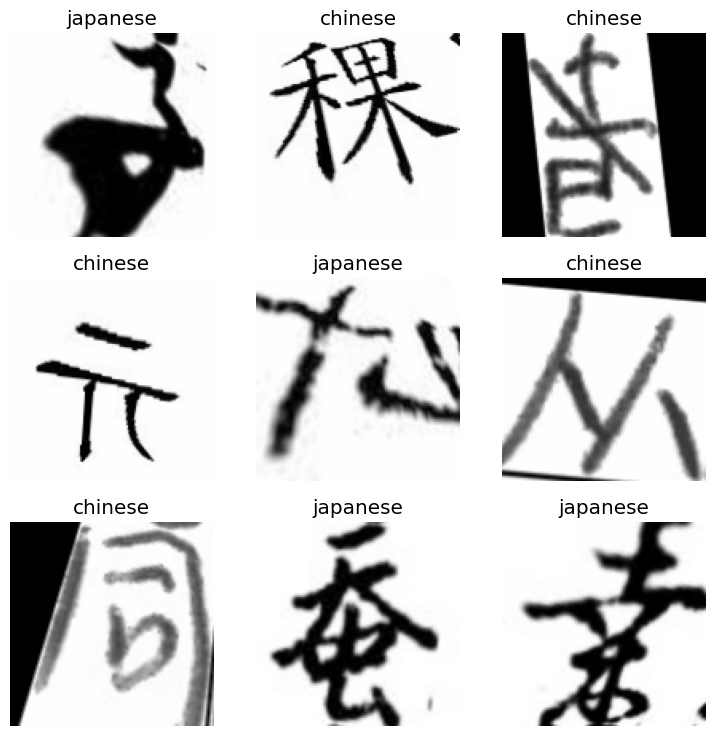

In [17]:
dls = language.dataloaders(destination_folder, bs = 10)
dls.train.show_batch()

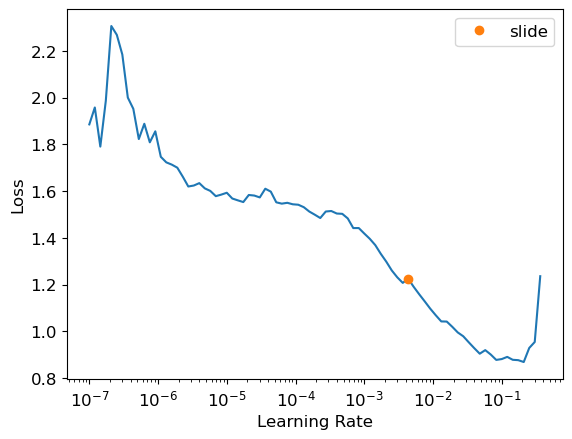

In [23]:
learner = None
learner = vision_learner(dls, resnet34, metrics=error_rate)
lr = learner.lr_find(suggest_funcs = [slide])

In [24]:
lr.slide

0.004365158267319202

In [27]:
learner.fine_tune(2, lr.slide)

epoch,train_loss,valid_loss,error_rate,time
0,0.073165,0.002043,0.001506,02:29


epoch,train_loss,valid_loss,error_rate,time
0,0.015052,0.002715,0.000000,04:01
1,0.006571,0.000112,0.000000,03:32


In [28]:
test = Path.cwd()/'Dataset'/'test'

In [30]:
test_set = [test/file for file in os.listdir(test)]
test_set

[Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/KaitiChineseStroke_val_000000000077.jpg'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/HandwrittenChineseStroke_val_0000000488.jpg'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/HandwrittenChineseStroke_val_0000000521.jpg'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese5.png'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/KaitiChineseStroke_val_000000000071.jpg'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese4.png'),
 Path('/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese2

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/KaitiChineseStroke_val_000000000077.jpg


('chinese', tensor(0), tensor([1.0000e+00, 6.8284e-08]))


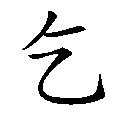

In [32]:
dest = test_set[0]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese5.png


('japanese', tensor(1), tensor([1.4228e-06, 1.0000e+00]))


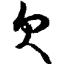

In [33]:
dest = test_set[3]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/HandwrittenChineseStroke_val_0000000521.jpg


('chinese', tensor(0), tensor([1.0000e+00, 5.8422e-13]))


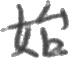

In [34]:
dest = test_set[2]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese2.png


('japanese', tensor(1), tensor([2.4201e-07, 1.0000e+00]))


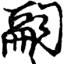

In [35]:
dest = test_set[6]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/HandwrittenChineseStroke_val_0000000410.jpg


('chinese', tensor(0), tensor([1.0000e+00, 1.9814e-15]))


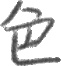

In [36]:
dest = test_set[8]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)

/home/agastya/notebooks/FastAI-course/self-implementation/02-mandarin-japaenese-classifier/Dataset/test/japanese3.png


('japanese', tensor(1), tensor([1.9487e-06, 1.0000e+00]))


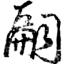

In [38]:
dest = test_set[10]
print(dest)
print(learner.predict(dest))
im = Image.open(dest)
im.to_thumb(128)